In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-shoppers-intention/online_shoppers_intention.csv


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Exploratory Data Analysis
* Understand user behavior, not just statistics
* Identify strong conversion signals
* Prepare stories for feature engineering
* Demonstrate product thinking

## 1.1 Dataset Overview

Dataset berisi 12.330 sesi pengguna e-commerce dengan:

* Behavioral features (page visits, duration)
* Technical features (browser, OS)
* Temporal features (Month, Weekend)
* Target: Revenue (binary)

In [2]:
df = pd.read_csv("/kaggle/input/online-shoppers-intention/online_shoppers_intention.csv")
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## 1.2 Dataset Shape & Info
* Campuran numerical & categorical
* Tidak ada missing value eksplisit
* Target sangat imbalanced

In [3]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

## 1.3 Target Distribution

* ± 15% transaksi menghasilkan revenue
* Accuracy tidak cocok → perlu precision/recall-aware metrics

In [4]:
df['Revenue'].value_counts(normalize=True)

Revenue
False    0.845255
True     0.154745
Name: proportion, dtype: float64

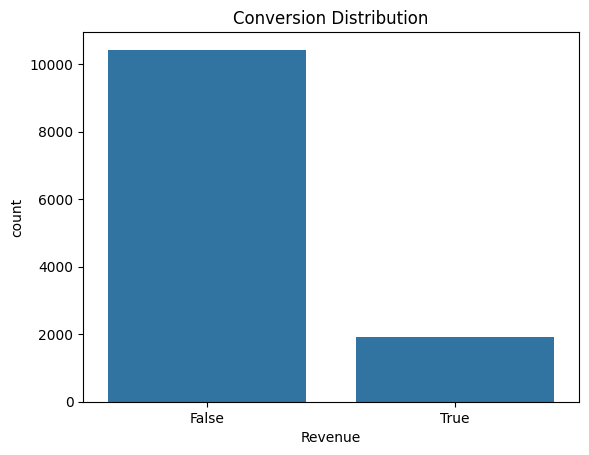

In [7]:
sns.countplot(x='Revenue', data=df)
plt.title("Conversion Distribution")
plt.show()

## 1.4 Behavioral Features Analysis

* Sesi dengan durasi ProductRelated lebih tinggi → lebih mungkin membeli
* Behavioral engagement = sinyal kuat konversi

In [8]:
behavioral_cols = [
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration'
]

df.groupby('Revenue')[behavioral_cols].mean()

,Administrative_Duration,Informational_Duration,ProductRelated_Duration
Revenue,,,
False,73.740111,30.236237,1069.987809
True,119.483244,57.611427,1876.209615


# 2. Data Preprocessing & Feature Engineering

## 2.1 Feature-Target Separation

In [9]:
X = df.drop(columns='Revenue')
y = df['Revenue']

## 2.2 Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## 2.3 Feature Type Identification

In [11]:
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object', 'bool']).columns

## 2.4 Preprocessing Pipeline

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [14]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_features),
    ('cat', categorical_pipeline, cat_features)
])

## 2.5 Class Imbalance Handling

In [17]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
scale_pos_weight

/tmp/ipykernel_55/550530817.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]


np.float64(5.463958060288335)

## 2.6 Final Dataset Summary

In [18]:
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Positive rate:", y.mean())

Train size: (9864, 17)
Test size: (2466, 17)
Positive rate: 0.15474452554744525


# 3. Modeling & Baseline Comparison

## 3.1 Evaluation Metric Selection
Karena data imbalanced, maka digunakan:
* Precision
* Recall
* F1-score
* ROC-AUC

## 3.2 Baseline Model: Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [20]:
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Month', 'VisitorType', 'Weekend'], dtype='object'))])),
                ('model', LogisticRegression(max_iter=1000))])

## 3.3 Tree-Based Model: Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'
    ))
])

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'O...'Browser', 'Region', 'TrafficType'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Month', 'VisitorType', 'Weekend'], dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

## 3.4 Gradient Boosting: XGBoost

In [22]:
from xgboost import XGBClassifier

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss',
        random_state=42
    ))
])

xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'O...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

## 3.5 Model Comparison

In [23]:
from sklearn.metrics import classification_report

models = {
    "Logistic Regression": logreg_pipeline,
    "Random Forest": rf_pipeline,
    "XGBoost": xgb_pipeline
}

for name, model in models.items():
    print(f"\n{name}")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))


Logistic Regression
              precision    recall  f1-score   support

       False       0.89      0.98      0.93      2084
        True       0.74      0.36      0.48       382

    accuracy                           0.88      2466
   macro avg       0.82      0.67      0.71      2466
weighted avg       0.87      0.88      0.86      2466


Random Forest
              precision    recall  f1-score   support

       False       0.92      0.97      0.94      2084
        True       0.74      0.52      0.61       382

    accuracy                           0.90      2466
   macro avg       0.83      0.74      0.78      2466
weighted avg       0.89      0.90      0.89      2466


XGBoost
              precision    recall  f1-score   support

       False       0.95      0.90      0.93      2084
        True       0.59      0.75      0.66       382

    accuracy                           0.88      2466
   macro avg       0.77      0.83      0.79      2466
weighted avg       0.90      

**Best model: XGBoost**
* Recall lebih baik pada class Revenue=True
* Menangkap non-linear behavioral patterns

# 4. Model Evaluation & Interpretability

## 4.1 Confusion Matrix

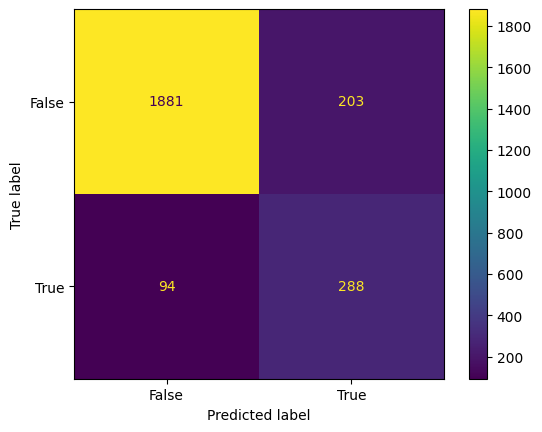

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    xgb_pipeline,
    X_test,
    y_test
)
plt.show()

## 4.2 Precision-Recall Trade-off

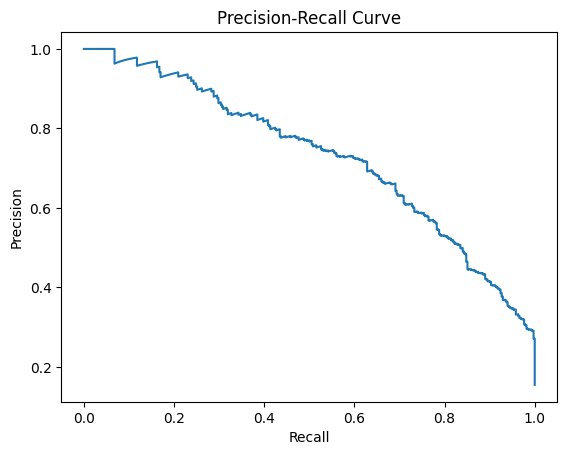

In [25]:
from sklearn.metrics import precision_recall_curve

y_prob = xgb_pipeline.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

**Business note:**
* Threshold bisa disesuaikan tergantung biaya false positive vs false negative

## 4.3 SHAP Interpretability
SHAP analysis was performed using a model-agnostic explainer wrapped around the XGBoost probability output to ensure compatibility with an sklearn-based pipeline.

In [34]:
import shap

### Transform Data

In [68]:
X_train_trans = xgb_pipeline.named_steps['preprocessor'].transform(X_train).astype(float)
X_test_trans  = xgb_pipeline.named_steps['preprocessor'].transform(X_test).astype(float)

In [41]:
# Check if all elements are float
def all_elements_float(arr):
    return all(isinstance(x, float) for x in arr)

In [69]:
model = xgb_pipeline.named_steps['model']

In [70]:
# sklearn wrapper
def model_predict(X):
    return model.predict_proba(X)[:, 1]

### SHAP Explainer

In [71]:
explainer = shap.Explainer(model_predict, X_train_trans)
shap_values = explainer(X_test_trans)

PermutationExplainer explainer: 2467it [05:12,  7.75it/s]                          


### Feature Names

In [73]:
num_features = X_train.select_dtypes(include=['int64','float64']).columns.tolist()

cat_features = X_train.select_dtypes(include=['object','bool']).columns.tolist()
ohe = xgb_pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .named_steps['onehot']

cat_names = ohe.get_feature_names_out(cat_features).tolist()
feature_names = num_features + cat_names

### SHAP Summary Plot

/tmp/ipykernel_55/3643738196.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


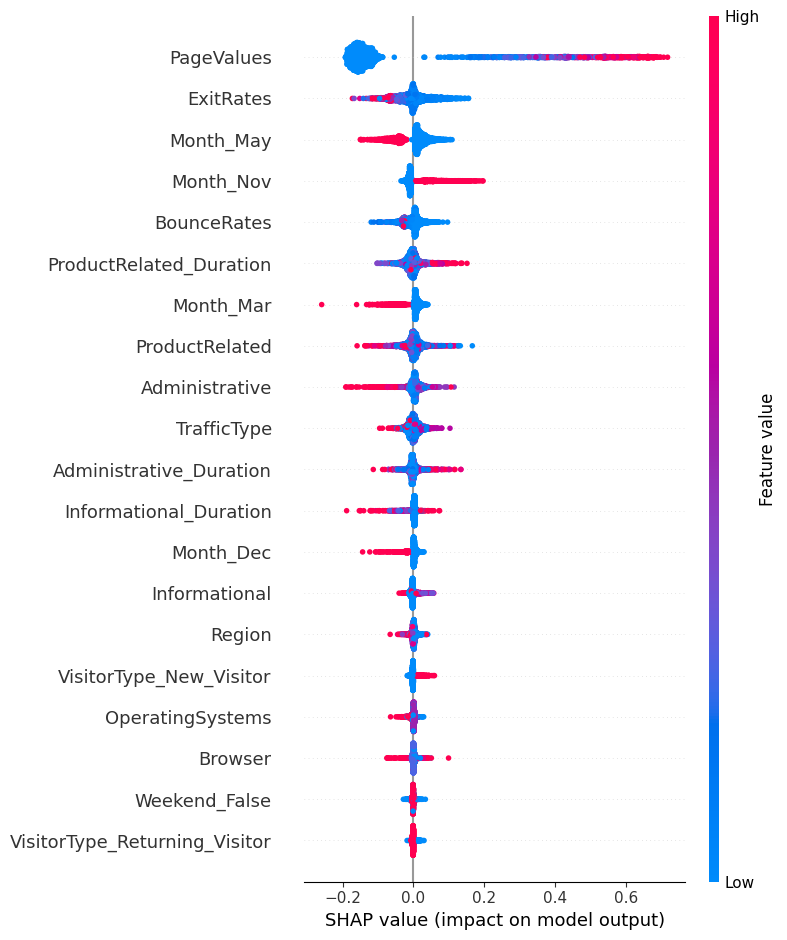

In [74]:
shap.summary_plot(
    shap_values.values,
    X_test_trans,
    feature_names=feature_names
)

# 5. Key Business Insights
* ProductRelated_Duration = driver utama konversi
* Returning visitors memiliki probabilitas purchase lebih tinggi
* Faktor temporal (Month, Weekend) berpengaruh signifikan
* Engagement > demographic signals

# 6. Limitations & Future Work

**Limitations**

* Data session-level, bukan user-level
* Tidak ada harga atau promo detail
* Static snapshot (no sequence modeling)

**Future Work**
* Threshold optimization berbasis cost
* SHAP interaction values
* Session sequence modeling (LSTM / Transformer)
* Uplift modeling untuk campaign targeting